# Predicting churn for a ride-sharing company

Company X, a ride-sharing company, is interested in predicting rider retention. In order to determine whether a user would churn, a sample dataset of users who signed up for an account during January 2014 was used in order to model rider behavior. Data was pulled on July 1, 2014.

## About the data
Users were considered 'active' if they had taken a trip in the 30 days prior to data extraction (July 1).

As data is proprietary, it has not been included in this repository.

The goal of this analysis was the understand which factors are the suitable predictors for retaining users and produce suggestions for retaining users.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from src.ensemble import EnsembleModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC

plt.style.use('ggplot')

## Preliminary data analysis and cleaning

Initial observation of the provided dataset shows 12 features by 40,000 entries.

In [3]:
churn = pd.read_csv('data/churn_train.csv')
churn.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


The variables from this dataset are defined as below:

__city:__ city this user signed up in <br> 
__phone:__ primary device for this user <br>
__signup_date:__ date of account registration; in the form `YYYYMMDD` <br>
__last_trip_date:__ the last time this user completed a trip; in the form `YYYYMMDD` <br>
__avg_dist:__ the average distance (in miles) per trip taken in the first 30 days after signup <br>
__avg_rating_by_driver:__ the rider’s average rating over all of their trips <br>
__avg_rating_of_driver:__ the rider’s average rating of their drivers over all of their trips <br>
__surge_pct:__ the percent of trips taken with surge multiplier > 1 <br>
__avg_surge:__ The average surge multiplier over all of this user’s trips <br>
__trips_in_first_30_days:__ the number of trips this user took in the first 30 days after signing up <br>
__luxury_car_user:__ TRUE if the user took a luxury car in their first 30 days; FALSE otherwise <br>
__weekday_pct:__ the percent of the user’s trips occurring during a weekday <br>

### Cleaning of data

Observation of the first few rows of data show that there are several missing values for `avg_rating_of_driver`. Using `churn.info()`, we see that of our 12 features, 3 of these columns have null values: 

    avg_rating_by_driver
    avg_rating_of_driver
    phone`
    
For the first 2 features, this may be because drivers and users did not rate their rider and driver, respectively. To keep these users, we can impute these null values with the mean rating for each driver:

    df['avg_rating_by_driver'].fillna(0.0, inplace=True)
    df['avg_rating_of_driver'].fillna(0.0, inplace=True)

In [4]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      39838 non-null float64
avg_rating_of_driver      33472 non-null float64
avg_surge                 40000 non-null float64
city                      40000 non-null object
last_trip_date            40000 non-null object
phone                     39681 non-null object
signup_date               40000 non-null object
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null bool
weekday_pct               40000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.4+ MB


Observing values `phone`, we see that the only values are `Android`, `iPhone`, and `nan`. We can make a new variable called `unknown` to capture these users.

    df['phone'].fillna(value='Unknown', inplace=True)

In [5]:
churn['phone'].unique()

array(['Android', 'iPhone', nan], dtype=object)

As drivers and users who did not have ratings may be a factor in retention, I engineered new boolean features to capture whether the trip consisted of a driver or user being rated. Categorical variables such as `city` and `phone` were transformed into binary dummy variables.

Finally, to create our target label, churn was defined as whether the last trip taken was before 30 days since the data was extracted (June 1, 2014). 

In [6]:
def clean_data(df):
    df['phone'].fillna(value='Unknown', inplace=True)
    df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

    df['churn'] = df['last_trip_date'] < '2014-06-01'

    df['no_rating_by_driver'] = df['avg_rating_by_driver'].isnull()
    df['signup_date'] = pd.to_datetime(df['signup_date'])
    df['signup_date'] = pd.to_numeric(df['signup_date'])
    df.drop('signup_date', axis=1, inplace=True)

    mean_rating_by_driver = df['avg_rating_by_driver'].mean()
    mean_rating_of_driver = df['avg_rating_of_driver'].mean()
    df['avg_rating_of_driver'].fillna(mean_rating_of_driver, inplace=True)
    df['avg_rating_by_driver'].fillna(mean_rating_by_driver, inplace=True)
    df['last_trip_date'] = pd.to_numeric(df['last_trip_date'])

    df = pd.get_dummies(df)

    y = df['churn'].values
    df.drop(['churn', 'last_trip_date'], axis=1, inplace=True)    
    X = df.values

    return df, X, y

In [7]:
churn_clean, X, y = clean_data(churn)
churn_clean.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,no_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Unknown,phone_iPhone
0,6.94,5.0,5.000000,1.00,0.0,0,False,100.0,False,1,0,0,1,0,0
1,8.06,5.0,5.000000,1.00,0.0,2,True,0.0,False,1,0,0,1,0,0
2,21.50,4.0,4.601697,1.00,0.0,1,True,100.0,False,0,0,1,0,0,1
3,9.46,5.0,4.601697,2.75,100.0,1,False,100.0,False,0,0,1,1,0,0
4,13.77,5.0,4.601697,1.00,0.0,0,False,100.0,False,0,0,1,0,0,1


### Exploratory data analysis

#### Featues by churn status

About 62% of our users have churned since January.

Plotting our numerical variables by churn, we can see some preliminary obvious differences in average distance, number of trips within the past 30 days, luxury care usage, and whether users were rated by the driver. 

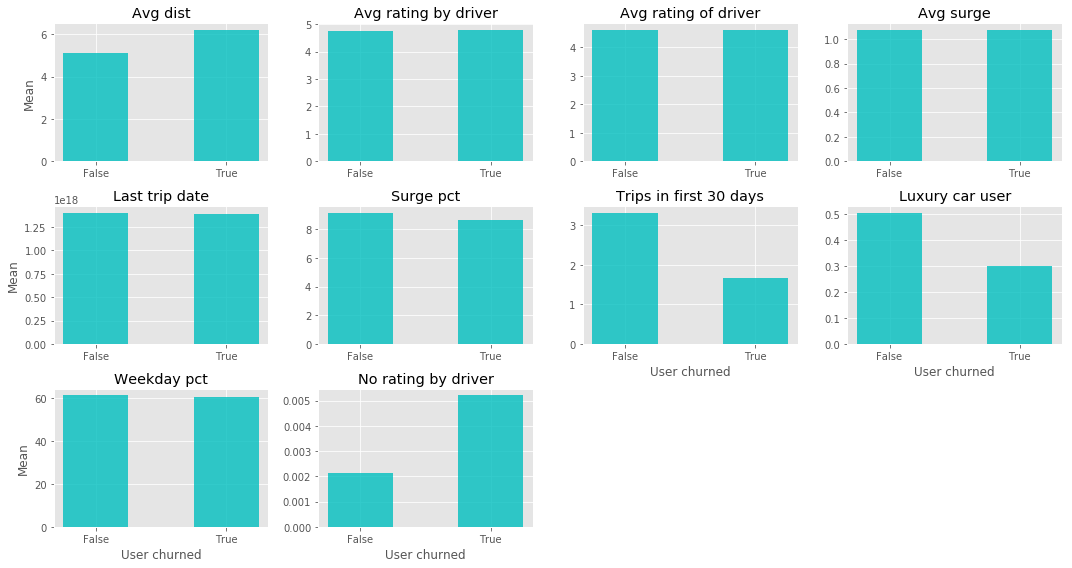

In [8]:
# Numerical variables

cols = churn.groupby('churn').mean().columns
vals_false = churn.groupby('churn').mean().values[0]
vals_true = churn.groupby('churn').mean().values[1]

fig = plt.figure(figsize=(15,8))

for i, means in enumerate(zip(vals_false, vals_true), 1):
    ax = fig.add_subplot(3,4,i)
    ax.bar(['False', 'True'], means, color='c', alpha=0.8, width=0.5)
    ax.set_title(cols[i-1].replace('_', ' ').capitalize())
    if i in [1,5,9]:
        ax.set_ylabel('Mean')
    if i in [7,8,9,10]:
        ax.set_xlabel('User churned')
    
plt.tight_layout();

In plotting these multi-category variables we can differences between cities, android and iphone users, luxury car users, and unrated versus rated users.

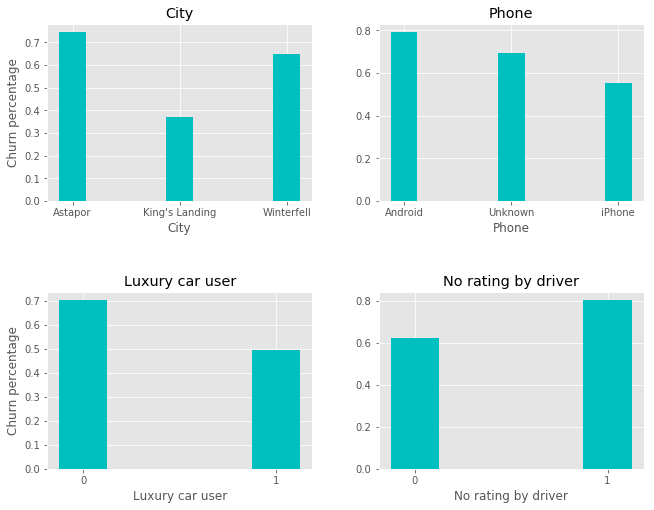

In [9]:
# Categorical variables
feats_cat = ['city',
                 'phone',
                 'luxury_car_user', 
                 'no_rating_by_driver']

fig = plt.figure(figsize=(10,8))

for i, feat in enumerate(feats_cat):
    
    # Calculate percentage of churn
    sums_churn = churn[churn['churn'] == True].groupby(feat)['churn'].count()
    totals = churn.groupby(feat)['churn'].count()
    perc_churn = pd.DataFrame(sums_churn / totals)
    
    ax = fig.add_subplot(2,2,i+1)
    ax.bar(perc_churn.index, perc_churn.iloc[:,0], color='c', width=0.25)
    
    if i%2 == 0:
        ax.set_ylabel('Churn percentage')
    if i in [2,3]:
        ax.set_xticks([0.0, 1.0])
    ax.set_xlabel(feat.replace('_', ' ').capitalize())

    ax.set_title(feat.replace('_', ' ').capitalize())

plt.tight_layout(pad=4);

#### Users may be using the service for occasional travel

Plotting the percentage of weekday trips a user had shows large spikes of users in the churned population. While we do not have information on the total number of trips for each user, we can speculate that users may be taking single or a low number of occasional trips (eg, to the airport for travel). 

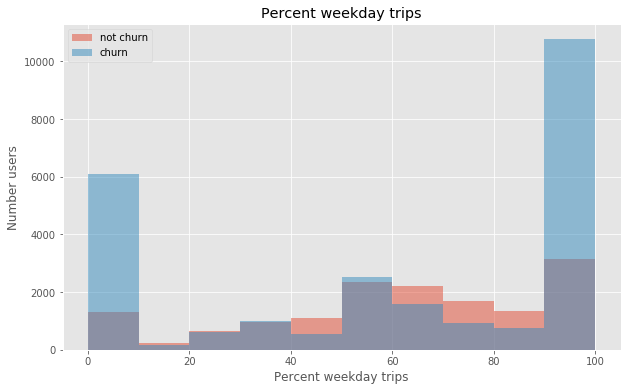

In [10]:
plt.figure(figsize=(10,6))
plt.hist(churn['weekday_pct'][churn['churn'] == 0], alpha=0.5, label='not churn')
plt.hist(churn['weekday_pct'][churn['churn'] == 1], alpha=0.5, label='churn')
plt.title('Percent weekday trips')
plt.xlabel('Percent weekday trips')
plt.ylabel('Number users')
plt.legend();

## Model testing and evaluation

To predict user retention, data was modeled using logistic regression, random forest, gradient boosting, k-nearest neighbors, support vector classifier and and ensemble model consisting of all models.

I used a series of metrics to evaluate these models, including accuracy, precision, recall, and F1 score.

Each model was initially used out of the box and then iteratively evaluated using a grid search of hyperparameters with 5-fold cross validation.

In [12]:
# Random forest model (best parameters chosen from grid search)
rf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=3, max_features=4,
            max_leaf_nodes=None, min_impurity_decrease=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=3, max_features=4,
            max_leaf_nodes=None, min_impurity_decrease=1e-07,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=2000, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [13]:
# Gradient boosting model (best parameters chosen from grid search)
gbc = GradientBoostingClassifier(learning_rate=.1,
                                 max_depth=4,
                                 max_features=1.0,
                                 min_samples_leaf=100,
                                 n_estimators=400)
gbc.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=1.0, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=400,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [14]:
# K nearest neighbors model (best parameters chosen from grid search)
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [15]:
# Logistic regression model (best parameters chosen from grid search)
logreg = Pipeline([('logreg', LogisticRegression())])
logreg.fit(X, y)

Pipeline(memory=None,
     steps=[('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [16]:
# SVC model (best parameters chosen from grid search)
svc = SVC(probability=True)
svc.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [17]:
# Ensemble model
ensemble = EnsembleModel([gbc,svc,logreg,knn])
ensemble.fit(X,y)
ensemble_preds = ensemble.predict(X)

The predicted probabilities, false positive rate (FPR), and true positive rate (TPR) were calculated for each model in order to compare and evaluate model performance

In [18]:
# Predict probabilities and calculate fpr/tpr for each model
y_pred_rf = rf.predict_proba(X)[:, 1]
fpr_rf, tpr_rf, thresholds = roc_curve(y, y_pred_rf)

y_pred_gbc = gbc.predict_proba(X)[:, 1]
fpr_gbc, tpr_gbc, thresholds = roc_curve(y, y_pred_gbc)

y_pred_knn = knn.predict_proba(X)[:, 1]
fpr_knn, tpr_knn, thresholds = roc_curve(y, y_pred_knn)

y_pred_log = logreg.predict_proba(X)[:, 1]
fpr_log, tpr_log, thresholds = roc_curve(y, y_pred_log)

y_pred_svc = svc.predict_proba(X)[:, 1]
fpr_svc, tpr_svc, thresholds = roc_curve(y, y_pred_svc)

y_pred_ens = np.mean([y_pred_rf, y_pred_gbc, y_pred_knn, y_pred_log, y_pred_svc], axis=0)
fpr_ens, tpr_ens, thresholds = roc_curve(y, y_pred_ens)

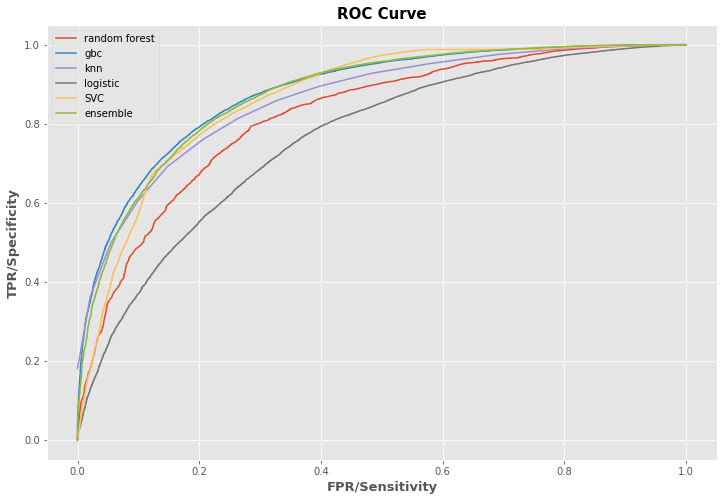

In [19]:
# Plot ROC curves for each model

plt.figure(figsize=(12,8))

plt.plot(fpr_rf, tpr_rf, label='random forest')
plt.plot(fpr_gbc, tpr_gbc, label='gbc')
plt.plot(fpr_knn, tpr_knn, label='knn')
plt.plot(fpr_log, tpr_log, label='logistic')
plt.plot(fpr_svc, tpr_svc, label='SVC')
plt.plot(fpr_ens, tpr_ens, label='ensemble')

plt.xlabel('FPR/Sensitivity', fontsize='13', fontweight='bold')
plt.ylabel('TPR/Specificity', fontsize='13', fontweight='bold')
plt.title('ROC Curve', fontsize='15', fontweight='bold')
plt.legend();

## Feature importances

As the gradient boosting model gave the superior performance of the models tested, I examined sklearn's feature importances method to determine the top variables attributing that may attribute to predicting churn. As numerical variables typically have higher feature importances compared to categorical variables, variables were only compared within these groups.

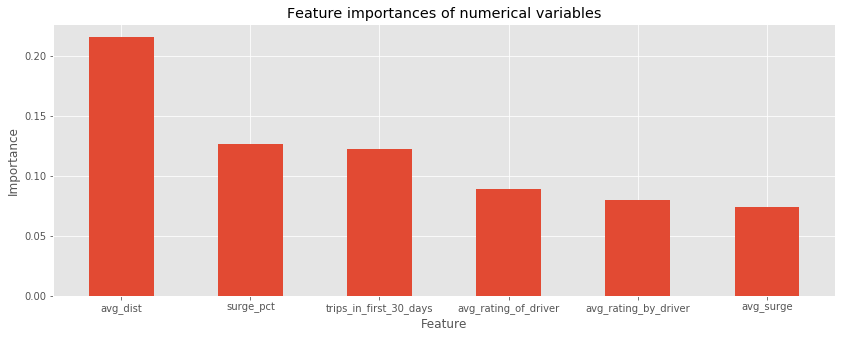

In [20]:
# Feature importances of numerical variables
feat_imports = pd.Series(gbc.feature_importances_, index=churn_clean.columns)

feat_import_num = feat_imports.loc[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'trips_in_first_30_days']].sort_values(ascending=False) 

plt.figure(figsize=(14,5))
plt.bar(feat_import_num.index, feat_import_num.values.ravel(), width=0.5)
plt.title('Feature importances of numerical variables')
plt.xlabel('Feature')
plt.ylabel('Importance');

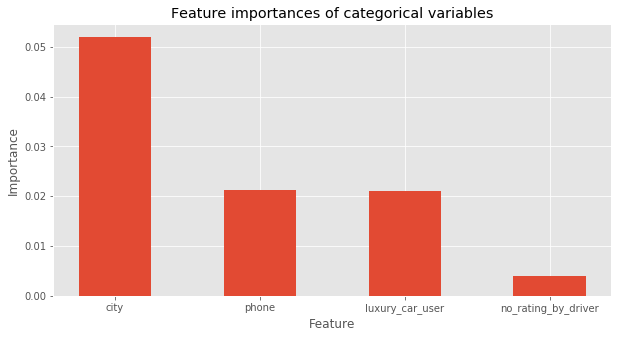

In [21]:
# Feature importances of categorical variables
feat_import_cat = feat_imports.loc[['luxury_car_user', 'no_rating_by_driver', 'city_Astapor', "city_King's Landing",
       'city_Winterfell', 'phone_Android', 'phone_Unknown', 'phone_iPhone']]
feat_import_cat.loc['city'] = feat_import_cat.loc['city_Astapor'] + feat_import_cat.loc["city_King's Landing"] + feat_import_cat.loc['city_Winterfell']
feat_import_cat.loc['phone'] = feat_import_cat.loc['phone_Android'] + feat_import_cat.loc["phone_Unknown"] + feat_import_cat.loc['phone_iPhone']
feat_import_cat.drop(['city_Astapor', "city_King's Landing", 'city_Winterfell', 'phone_Android', 'phone_Unknown', 'phone_iPhone'], inplace=True)
feat_import_cat = feat_import_cat.sort_values(ascending=False)

plt.figure(figsize=(10,5))
plt.bar(feat_import_cat.index, feat_import_cat.values.ravel(), width=0.5)
plt.title('Feature importances of categorical variables')
plt.xlabel('Feature')
plt.ylabel('Importance');

For numerical variables, the average distance, percentage of time that a user experienced surge, and the number of trips a user took in their first 30 days were listed as the top predictors for retention. Users who had shorter average distances and fewer numbers of trips had increased churn. Unexpectedly, those who churned has slightly smaller differences percentages in churn. This may be due to the high number of one-time use cases for users who churned that never experienced surge pricing.

For categorical variables, city location, phone type, and luxury car usage were more significant. Combined with our preliminary data analysis, we can see that Astapor, Android users, and non-luxury car users show greater churn. 

## Conclusion

In [22]:
churn[churn['city'] == "King's Landing"]['churn'].mean()

0.37217583497053047

Based on this analysis and modeling exercise, I suggest several actions that Company X can take in order to reduce churn:
    
 - **Focus on users in Astapor:** While the actual city names of this dataset have been redacted, there are clear differences in percentage of churn between locations. At 74.5% of users churned, Astapor has the highest churn rate, compared to 37.2 for King's Landing. 
 - **Spend engineering or UX resources on Android app:** As users with Android phone have higher churn rates, the android app may have provide a different user experience compared to the iPhone app. Investigation of user experience with the Android app may be warrented if there are significant differences between mobile phone versions. Additionally, this difference may be correlated with differences in user socioeconomic characteristics as Iphone are more expensive.
 - **Non-luxury car satisfaction:** Luxury cars users showed lower rates of churn compared to non-luxury car users. While this may be due to socioeconomic differences between users, economy car trips may also be inferior service that is affecting user experience. Ensuring consistent driver habits and service across vehicles may be investigated as a way to improve user retention
 - **Promote new users:** As trips taken in the first month of sign up has an effect on retention, focusing on keeping new users engaged in the service may help establish habits that help users continue to engage 
